# [aftershoq]: A guide to QCL optimization

Author: Martin Franckie, Sept. 2018

This guide will show you how to:

- Set up optimization environment
- Optimize a model function with different methods
- Optimize quantum cascade structures with a model interface

This guide uses the information algorithm with parallel trials (IAPT) from Strongin and Sergeyev, “Global Optimization with Non-Convex Constraints: Sequential and Parallel Algorithms”, Kluwer Academic Publishers, London (2000), as well as a method based on Gaussian process regression (GP).

First make sure you have run "python setup.py install" or that your pythonpath directs to "aftershoq/" and "aftershoq/hilbert_curve/", e.g. by setting it in ~/.bash_profile/: 

export PYTHONPATH="path-to/aftershoq/:path-to/aftershoq/hilbert_curve/:$PYTHONPATH"

Setting up and defining test function:

In [1]:
from aftershoq.interface import NDtestfunc
from aftershoq.numerics import Paraopt, Gaussopt
from aftershoq.utils import HilbertUtil
from hilbert import HilbertCurve
import numpy as np
import random as rm
from matplotlib import pyplot as pl

# Number of dimensions:
ND = 2

# generate the Hilbert curve:
p = 7
hc = HilbertCurve( p, ND )
hutil = HilbertUtil( hc )

Now we define the optimization scheme to be used (Paraopt implements IAPT, Guassopt implements Gaussian process regression):

In [2]:
scheme = 1 # 0= IAPT, 1= GP

tol, its, Nproc, r = 0.0005, 100, 1, 0.3

if scheme==0:
    # Creating the optimization object for IAPT:
    opt = Paraopt(tolerance=tol*hutil.imax, maxiter=its, 
                  procmax=Nproc, r=r)
elif scheme==1:
    # Creating the optimization object for GP:
    opt = Gaussopt(tolerance=tol*hutil.imax, maxiter=its, procmax=Nproc,  
                   sigma = 10, l = hutil.imax*0.01, sigma_noise=0.05,
               padding=1000, sigma_noise_max = 5)

The following code blocks can be evaluated separately.
The first one tests the algorithms for a model function (fast check for different schemes and dimensions), the second one uses an actual QCL simulation model to optimize a QCL.

## Test function minimum search

old theta =  [10, 1365.25, 0.05] [73.02591254]
Optimization terminated successfully.
         Current function value: 19.690856
         Iterations: 25
         Function evaluations: 66
         Gradient evaluations: 66
new theta =  [1.98878844e+00 2.81802186e+03 6.84294325e-01] [19.69085617]
[array([10918.00564593])]
old theta =  [10, 1365.25, 0.05] [73.02591254]
Optimization terminated successfully.
         Current function value: 19.690856
         Iterations: 25
         Function evaluations: 66
         Gradient evaluations: 66
new theta =  [1.98878844e+00 2.81802186e+03 6.84294325e-01] [19.69085617]
[array([10918.00564593])]
Converged:  0
old theta =  [10, 1260.2307692307693, 0.05] [73.80928738]
Optimization terminated successfully.
         Current function value: 20.168142
         Iterations: 22
         Function evaluations: 59
         Gradient evaluations: 59
new theta =  [2.54060820e+00 6.48975612e+03 7.23674904e-01] [20.16814219]
[array([8395.73851502])]
Converged:  0
ol

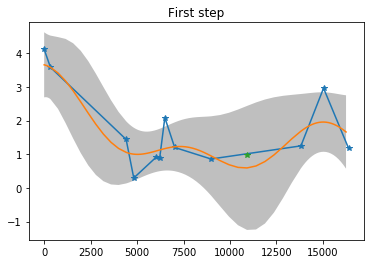

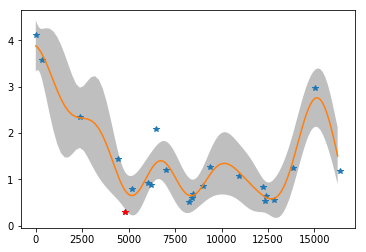

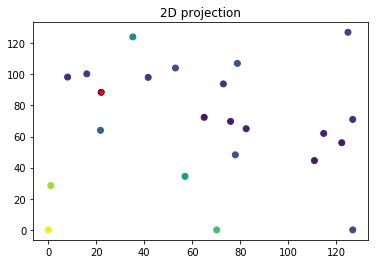

In [36]:
# Model function

# define the model interface. This is a simple test.
model = NDtestfunc(ND)

# initial points are random along the Hilbert curve
N0 = 10
x0 = []
y0 = []
x0.append(0.)
[x0.append(rm.random()*hutil.imax) for _ in range(N0)]
x0.append(hutil.imax)

x0 = np.sort(x0)

# To retreive coordinates, we have to scale by 2^p. opt will minimize,
# hence we append the negative of the merit function:
[y0.append(-model.getMerit(hutil.interp_coords_from_dist(xx)/2.**hutil.p)) 
 for xx in x0]

opt.addpoints(x0, y0)

newx = opt.nextstep()
if newx == -1:
    print("Failed to find new x-points from given input!")
    exit(1)
print(newx)
newy = []
[newy.append(-model.getMerit(hutil.interp_coords_from_dist(xx))) for xx in newx]

if scheme==1:
    xt1 = opt.xt
    mean1 = np.squeeze(opt.mean)
    var1 = np.reshape( np.abs( np.diag( opt.cov ) ), (opt.Nx,1) )


conv = opt.minimize_parameters(model, hutil)

print ("Convergence: " + str(conv) + " after " + str(opt.iter) + " iterations.")

optpointHC = opt.getbest()
optpointND = hutil.interp_coords_from_dist(optpointHC[0])



points = []
xND = []
yND = []
for x in opt.x:
    point = hutil.interp_coords_from_dist(x)
    xND.append(point[0])
    yND.append(point[1])
    points.append(point)
    
# plotting the results:

pl.figure(1)
pl.plot(x0, y0, '-*')

if scheme==1:
    pl.plot(xt1, mean1)
    pl.fill_between(np.squeeze(xt1), mean1-np.squeeze(2*np.sqrt(var1)),
                    mean1+np.squeeze(2*np.sqrt(var1)), 
                    facecolor = "grey", alpha=0.5)
    
pl.plot(newx, newy, '*')
pl.title("First step")

pl.figure(2)
if scheme==0:
    pl.plot(opt.x, opt.y, '-*')
elif scheme==1:
    pl.plot(opt.x, opt.y, '*')
    
pl.plot(opt.getbest()[0], opt.getbest()[1], 'r*')

if scheme==1:
    mean = np.squeeze(opt.mean)
    var = np.reshape( np.abs( np.diag( opt.cov ) ), (opt.Nx,1) )
    pl.plot(opt.xt, mean)
    pl.fill_between(np.squeeze(opt.xt), mean-np.squeeze(2*np.sqrt(var)),
                    mean+np.squeeze(2*np.sqrt(var)), 
                    facecolor = "grey", alpha=0.5)

pl.figure(3)

pl.scatter(xND, yND, c=np.squeeze(opt.y))
pl.title("2D projection")
pl.hold
pl.plot(optpointND[0], optpointND[1], 'r*')

pl.show()



## Optimizing a QC structure with a simulation model

dopindex = []
Dim = 16, p = 7, imax = 5192296858534827628530496329220095, pmax = 127
Simulation is running...
Simulation is running...
Simulation is running...
Simulation is running...
Simulation is running...
Simulation is running...
Simulation is running...
Simulation is running...
Simulation is running...
Simulation is running...
Simulation is running...
Simulation is running...


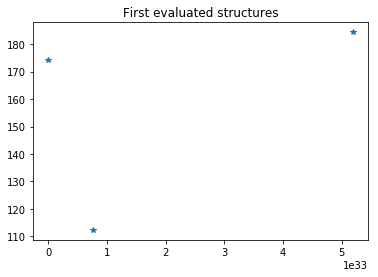

old theta =  [10, 1.730765619511609e+33, 0.05] [402.71852468]
Optimization terminated successfully.
         Current function value: 18.641048
         Iterations: 6
         Function evaluations: 26
         Gradient evaluations: 26
new theta =  [1.61770040e+02 1.73076562e+33 5.00000000e+00] [18.6410484]
old theta =  [10, 1.298074214633707e+33, 0.05] [477.83441553]
         Current function value: 24.994054
         Iterations: 7
         Function evaluations: 164
         Gradient evaluations: 153
new theta =  [1.52294452e+02 1.29807421e+33 5.00000000e+00] [24.99405444]
old theta =  [10, 1.0384593717069656e+33, 0.05] [456.99560627]
Optimization terminated successfully.
         Current function value: 29.958958
         Iterations: 6
         Function evaluations: 24
         Gradient evaluations: 24
new theta =  [1.32926445e+02 1.03845937e+33 1.80605880e-02] [29.95895825]
old theta =  [10, 8.653828097558046e+32, 0.05] [449.34760043]
Optimization terminated successfully.
         Cur

old theta =  [10, 1.9230729105684546e+32, 0.05] [24610.35682029]
         Current function value: 183.425270
         Iterations: 4
         Function evaluations: 103
         Gradient evaluations: 91
new theta =  [3.54240548e+02 1.92307291e+32 5.00000000e+00] [183.42526996]
Converged!
1
old theta =  [10, 1.8543917351910098e+32, 0.05] [16359.88176258]
         Current function value: 185.412715
         Iterations: 6
         Function evaluations: 187
         Gradient evaluations: 175
new theta =  [2.54277193e+02 1.85439174e+32 5.00000000e+00] [185.41271462]
Converged!
1
old theta =  [10, 1.7904471925982164e+32, 0.05] [64033.90959937]
         Current function value: 210.449380
         Iterations: 29
         Function evaluations: 1349
         Gradient evaluations: 1339
new theta =  [6.67242634e+02 1.79044719e+32 5.00000000e+00] [210.44937978]
Converged!
1
old theta =  [10, 1.7307656195116092e+32, 0.05] [41636.81176653]
         Current function value: 212.630773
         Iterations

Converged!
1
old theta =  [10, 1.0384593717069655e+32, 0.05] [609899.68984826]
         Current function value: 420.839936
         Iterations: 3
         Function evaluations: 91
         Gradient evaluations: 79
new theta =  [7.72585795e+02 1.03845937e+32 5.00000000e+00] [420.83993565]
Converged!
1
old theta =  [10, 1.018097423242123e+32, 0.05] [530229.51151228]
         Current function value: 419.089035
         Iterations: 3
         Function evaluations: 88
         Gradient evaluations: 76
new theta =  [8.65170294e+02 1.01809742e+32 5.00000000e+00] [419.08903527]
Converged!
1
old theta =  [10, 9.98518626641313e+31, 0.05] [499333.29610452]
         Current function value: 435.212592
         Iterations: 3
         Function evaluations: 92
         Gradient evaluations: 80
new theta =  [2.04444165e+02 9.98518627e+31 5.00000000e+00] [435.21259196]
Converged!
1
old theta =  [10, 9.79678652553741e+31, 0.05] [472784.76485914]
         Current function value: 442.317462
         Iterat

Converged!
1
old theta =  [10, 7.112735422650448e+31, 0.05] [617793.04103668]
         Current function value: 560.739983
         Iterations: 3
         Function evaluations: 99
         Gradient evaluations: 87
new theta =  [2.60038857e+02 7.11273542e+31 5.00000000e+00] [560.73998307]
Converged!
1
old theta =  [10, 7.016617376398416e+31, 0.05] [576000.01030331]
         Current function value: 563.902874
         Iterations: 3
         Function evaluations: 101
         Gradient evaluations: 89
new theta =  [2.70887044e+02 7.01661738e+31 5.00000000e+00] [563.90287445]
Converged!
1
old theta =  [10, 6.923062478046437e+31, 0.05] [535971.5957975]
         Current function value: 567.068482
         Iterations: 3
         Function evaluations: 96
         Gradient evaluations: 84
new theta =  [2.82885193e+02 6.92306248e+31 5.00000000e+00] [567.0684818]
Converged!
1
old theta =  [10, 6.83196955070372e+31, 0.05] [497581.11806825]
         Current function value: 570.138480
         Iterati

KeyboardInterrupt: 

In [7]:
from aftershoq.interface import Isewlab
from aftershoq.qcls import EV2416
from aftershoq.structure import Sgenerator
from aftershoq.numerics.runplatf import Local
from aftershoq.materials import GaAs
import aftershoq.utils.systemutil as su

s = EV2416()

dw = []
[dw.append(l.width*0.10) for l in s.layers]

sg = Sgenerator(s, dw)
# keep binpath = "" if binary is in main path
binpath = ""
su.mkdir("demo/")
wdpath = su.abspath("demo/")
pltfm = Local()

Ns = 3
coords = sg.genRanHilbertStructs(Ns, p)

# Choose your model:
# model = Inegf(binpath, pltfm, GaAs() )
# model = Isewself(binpath, pltfm, [GaAs(), AlGaAs(x=0.15)])
model = Isewlab(binpath + "sewlab", pltfm, GaAs())

model.numpar["efield0"] = -0.150
model.absorption_params["min-photon-energy"] = 0.010
model.absorption_params["max-photon-energy"] = 0.020

model.runStructures(sg.structures, wdpath)
model.waitforproc(3, "Simulation is running...")
model.gatherResults(sg.structures, wdpath)
opt.x = []
opt.y = []
x0, y0 = opt.addEvaldPoints(model, sg, wdpath, coords)

pl.figure(6)
pl.plot(x0, y0, '*')
pl.title("First evaluated structures")
pl.show()

conv = opt.minimize(model, sg, wdpath)

print( "Convergence: " + str(conv) )

pl.figure(7)
pl.plot(opt.x,opt.y,'*')
if scheme==1:
    mean = np.squeeze(opt.mean)
    var = np.reshape( np.abs( np.diag( opt.cov ) ), (opt.Nx,1) )
    pl.plot(opt.xt, mean)
    pl.fill_between(np.squeeze(opt.xt), mean-np.squeeze(2*np.sqrt(var)),
                    mean+np.squeeze(2*np.sqrt(var)), 
                    facecolor = "grey", alpha=0.5)
pl.show()